In [92]:
# 한글깨짐방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [93]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rc("font", family='NanumBarunGothic')
plt.rc("font", family='NanumBarunGothic')
# 마이너스 사인 수정
mpl.rc('axes', unicode_minus=False)



In [94]:
df = pd.read_csv('vgames2.csv')
df = df.drop('Unnamed: 0', axis = 1)

df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [95]:
df.dtypes

Name            object
Platform        object
Year           float64
Genre           object
Publisher       object
NA_Sales        object
EU_Sales        object
JP_Sales        object
Other_Sales     object
dtype: object

In [96]:
#결측치 드롭
df = df.dropna()

#unique 값 인트로 잘 보게 하기 위해서 
df['Year'] = df['Year'].astype(int)

df['Year'].unique()

array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
          9,   97, 1995, 1993, 2012, 1987, 1982,   11, 1994, 1990,   15,
       1992, 1991, 1983, 1988, 1981,    3, 1989,   96,    6,    8, 1986,
          1,    5,    4,   10,   98,    7,   16,   86,   14,   95, 2017,
       1980, 2020,    2,   13,    0,   12,   94])

# **Year 칼럼 전처리**



*    위와 같이 .unique() 결과로 보면 이상한 년도 값들이 아래와 같이 나온다. 

    3, 6, 8, 1, 0, 2, 7, 5, 4, 9, 

    11, 15, 10, 16, 14, 13, 12, 

    97, 96, 94, 98, 86, 95

*   0-9 사이의 숫자들은 그냥 드롭
*   10-16 사이의 숫자들에는 2000을 더한다.
*   86-98 숫자들에는 1900을 더한다.




In [97]:
# 0-9 사이의 숫자들은 그냥 드롭

df = df.drop(df[df['Year'] < 10].index)
df['Year'].unique()

array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
         97, 1995, 1993, 2012, 1987, 1982,   11, 1994, 1990,   15, 1992,
       1991, 1983, 1988, 1981, 1989,   96, 1986,   10,   98,   16,   86,
         14,   95, 2017, 1980, 2020,   13,   12,   94])

In [98]:
# 10-16 사이의 숫자들에는 2000을 더한다.

df2000 = df[(df['Year'] <= 16) & (df['Year'] >= 10)].index
for i in df2000:
    df.loc[i, 'Year'] = df.loc[i, 'Year'] + 2000

# 86-98 숫자들에는 1900을 더한다.
df1900 = df[(df['Year'] <= 98) & (df['Year'] >= 86)].index
for i in df1900:
    df.loc[i, 'Year'] = df.loc[i, 'Year'] + 1900

df['Year'].unique()


array([2008, 2009, 2010, 2005, 2011, 2007, 2001, 2003, 2006, 2014, 2015,
       2002, 1997, 2013, 1996, 2004, 2000, 1984, 1998, 2016, 1985, 1999,
       1995, 1993, 2012, 1987, 1982, 1994, 1990, 1992, 1991, 1983, 1988,
       1981, 1989, 1986, 2017, 1980, 2020])

# **Sales 칼럼 전처리**

*   if K 포함시, K 대신 * 1000
*   elif M 포함시, M 대신 * 1000000
*   else 그 외 그냥 숫자만 있으면 * 1000000






In [99]:
df_reset = df.reset_index(drop = True)
#모든 매출 칼럼에 대하여 전처리
for i in df_reset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]:
    for j in range(len(df_reset)):
        #K를 포함하고 있다면 1000 곱해주기
        if re.compile(r'K').search(str(df_reset[i].loc[j])): 
            df_reset[i].loc[j] = float(df_reset[i].loc[j].replace('K','')) * 1000
        #M을 포함하고 있다면 100만 곱해주기
        elif re.compile(r'M').search(str(df_reset[i].loc[j])): 
            df_reset[i].loc[j] = float(df_reset[i].loc[j].replace('M', '')) * 1000000
        #그 외 M기준이므로 100만 곱해주기
        else: 
            df_reset[i].loc[j] = float(str(df_reset[i].loc[j])) * 1000000

In [100]:
df_reset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = df_reset[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].astype(int)

df_reset['Total_Sales'] = df_reset['NA_Sales'] + df_reset['EU_Sales'] + df_reset['JP_Sales'] + df_reset['Other_Sales']


# **지역에 따라서 선호하는 게임 장르가 다를까?**

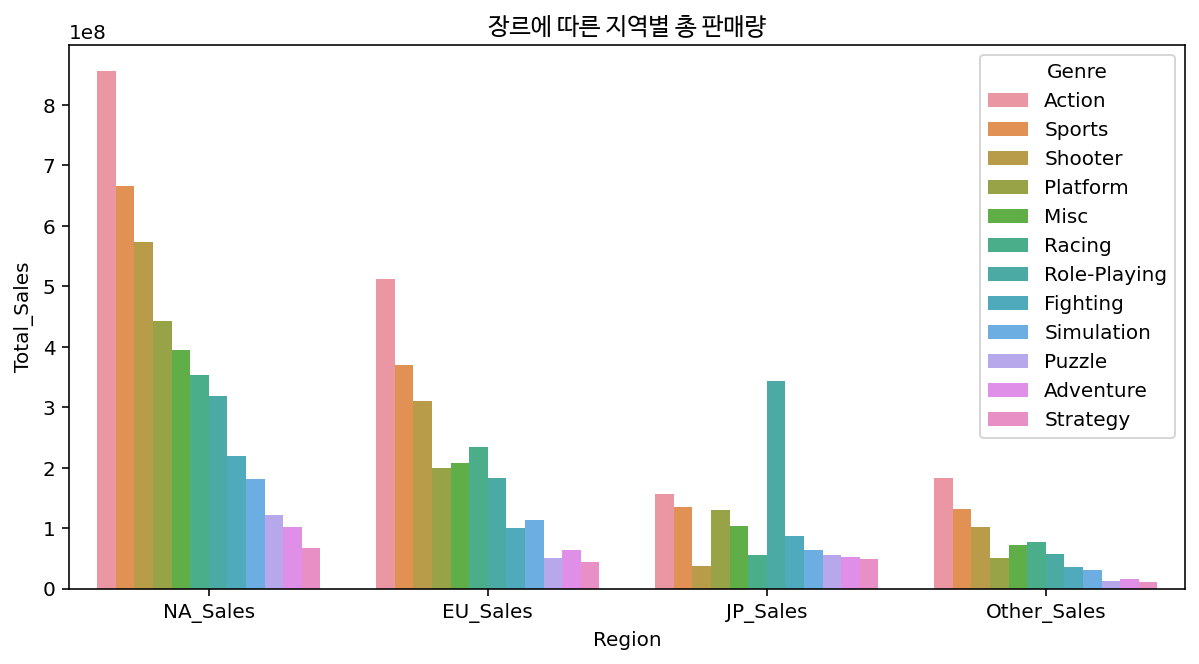

In [101]:
df_group = df_reset[['Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales']].groupby('Genre').sum()
df_group.reset_index(inplace=True)

df_tidy = df_group.melt(id_vars='Genre')
df_tidy.rename(columns={'variable':'Region','value':'Total_Sales'}, inplace=True)
df_tidy = df_tidy.sort_values(by = ['Total_Sales'], ascending=False).head(50)
import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(x='Region', y='Total_Sales', hue='Genre', data = df_tidy)
plt.title('장르에 따른 지역별 총 판매량', fontproperties = fontprop);

# **연도별 게임의 트렌드가 있을까?**

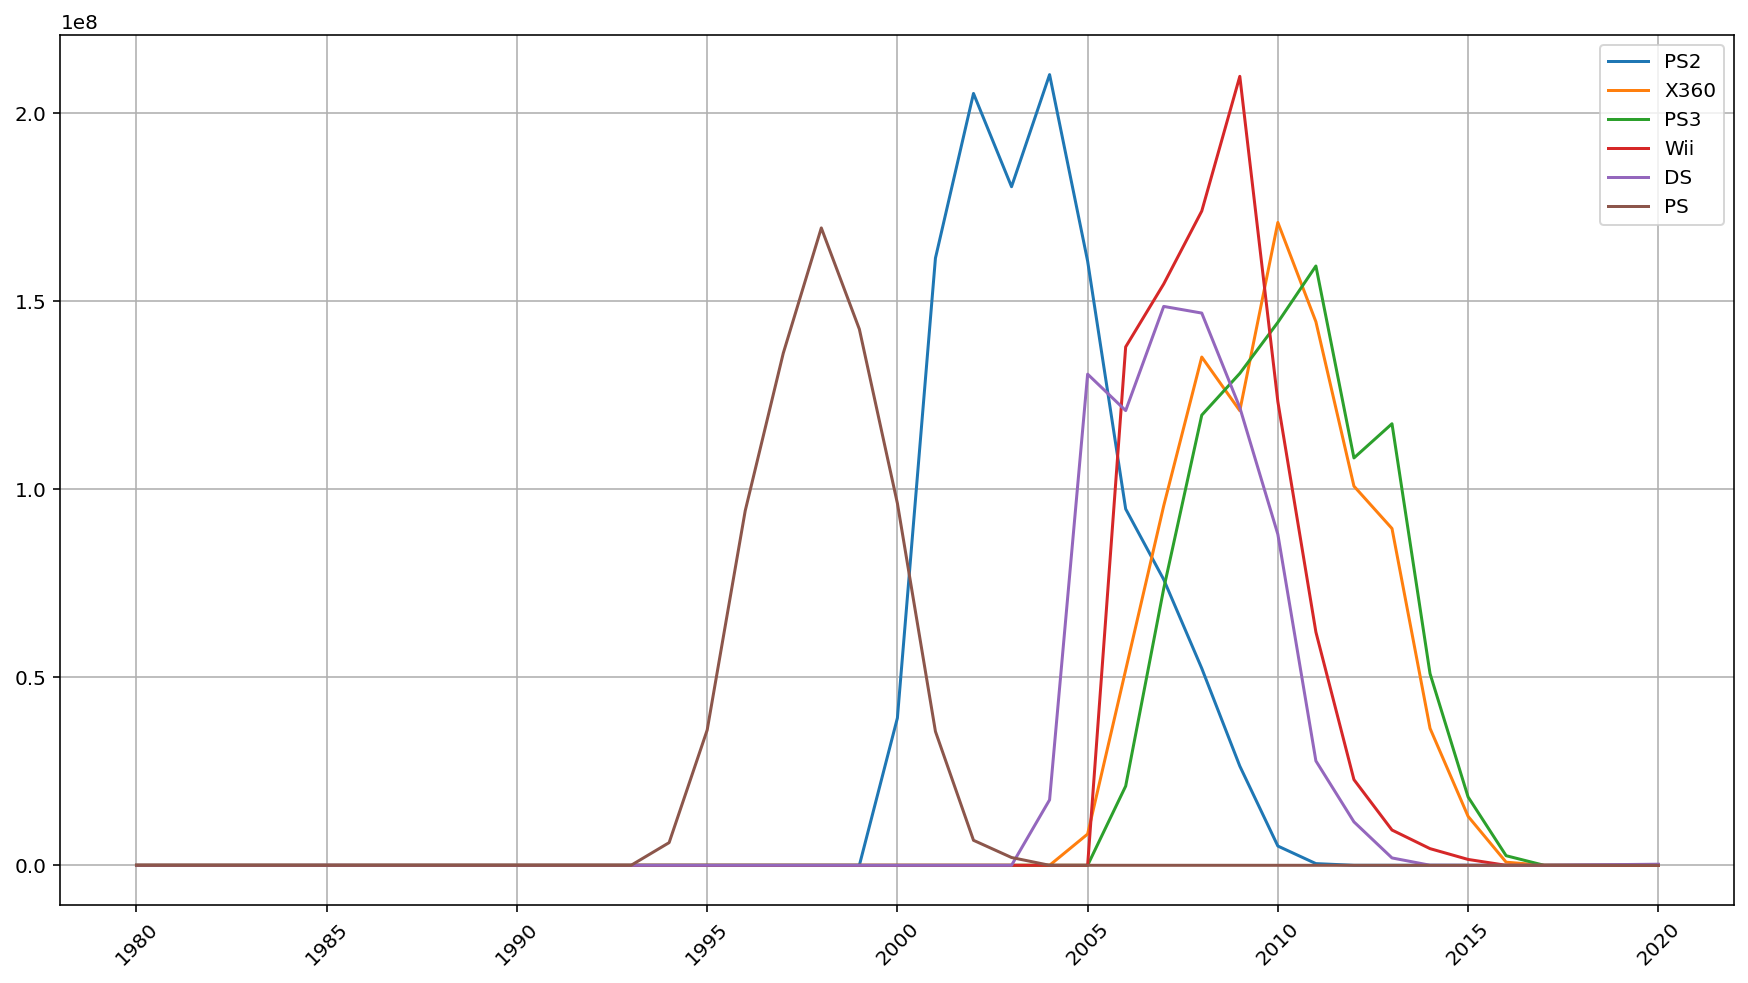

In [102]:

year_sales_platform = df_reset.pivot_table(values = 'Total_Sales', index = 'Year', columns = 'Platform', aggfunc = 'sum', fill_value = 0, margins = True)
year_sales_platform_top = year_sales_platform[['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']].drop('All', axis=0)

labels_platform = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

plt.figure(figsize = (15, 8))
plt.plot(year_sales_platform_top)
plt.xticks(rotation = 45)
plt.grid(True)
plt.legend(labels_platform)
plt.show();

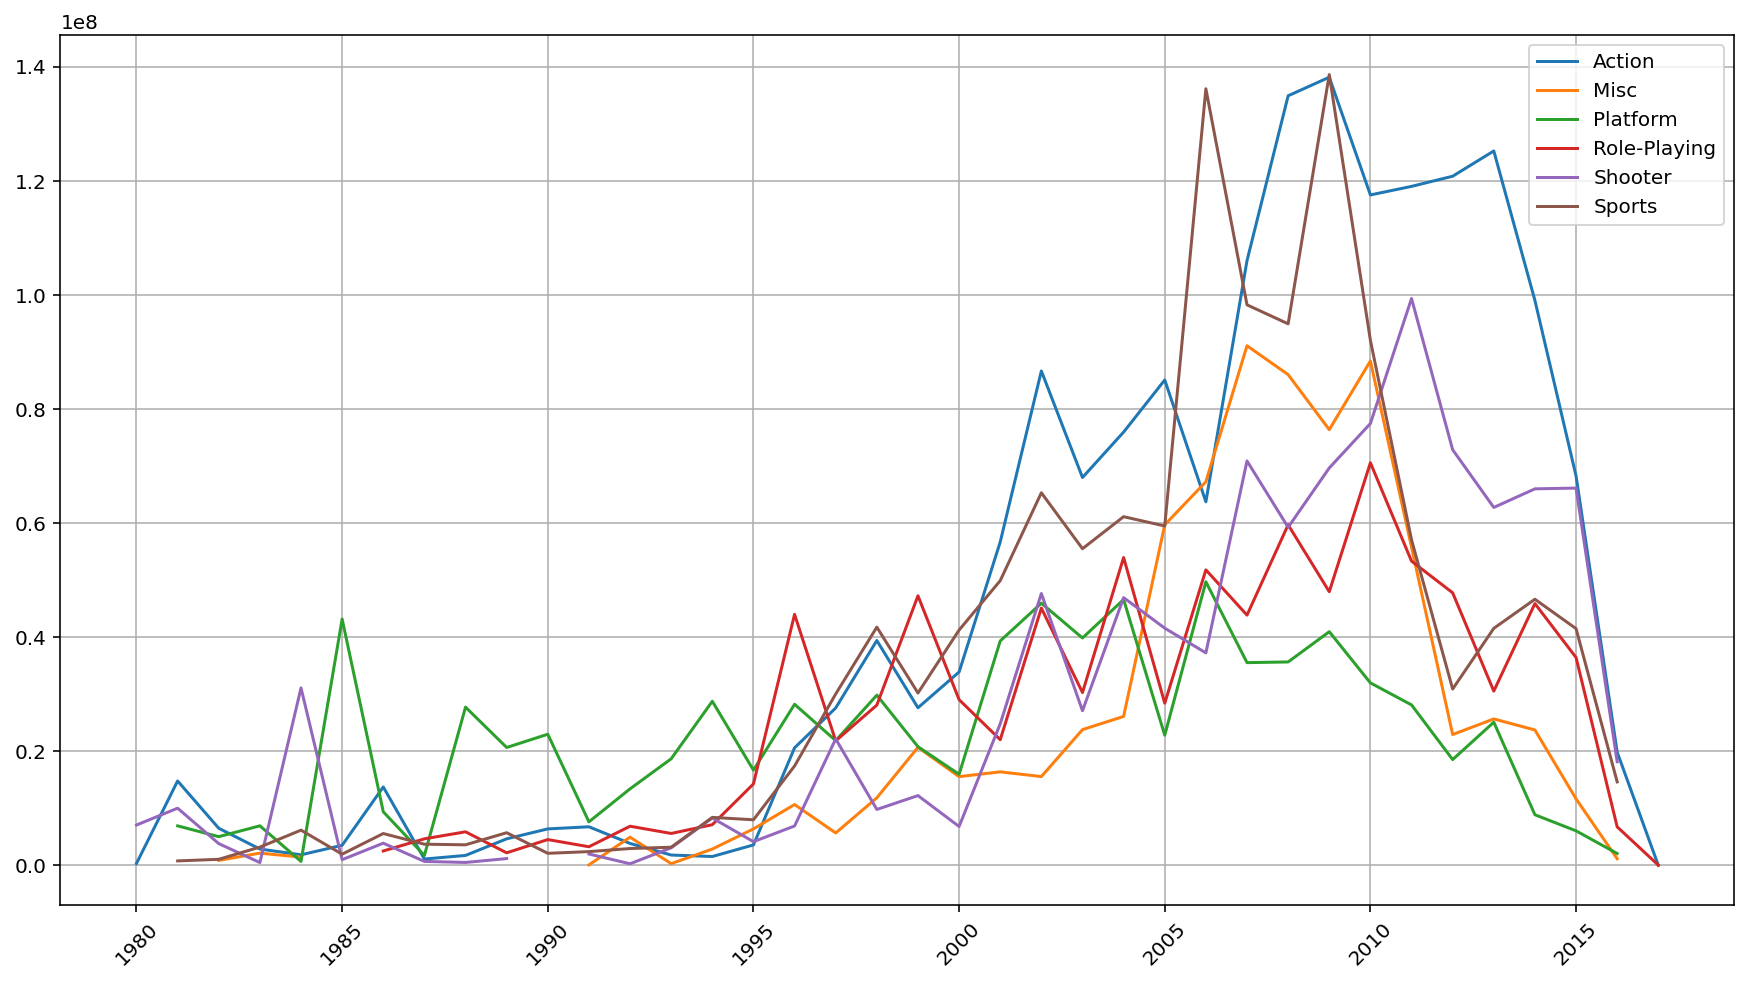

In [103]:

# Global_Sales과 Year, Genre을 한번에 보기위한 데이터 준비하기

year_sales_genre = df_reset.pivot_table(values = 'Total_Sales', index = 'Year', columns = 'Genre', aggfunc = 'sum', margins = True)
year_sales_genre_top = year_sales_genre[['Action', 'Misc', 'Platform', 'Role-Playing', 'Shooter', 'Sports']].drop('All', axis=0)
year_sales_genre_top.tail(10)
labels_genrn = ['Action', 'Misc', 'Platform', 'Role-Playing', 'Shooter', 'Sports']

plt.figure(figsize = (15, 8))
plt.plot(year_sales_genre_top)
plt.xticks(rotation = 45)
plt.grid(True)
plt.legend(labels_genrn)
plt.show();

# **출고량이 높은 게임에 대한 분석 및 시각화 프로세스**

In [104]:
df_max = df_reset.sort_values(by = ['Total_Sales'], ascending=False).head(50)
df_max.head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2843,Wii Sports,Wii,2006,Sports,Nintendo,41490000,29020000,3770000,8460000,82740000
4097,Super Mario Bros.,NES,1985,Platform,Nintendo,29080000,3580000,6810000,770000,40240000
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3275,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
7649,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11270000,8890000,10220000,1000000,31380000
1184,Tetris,GB,1989,Puzzle,Nintendo,23200000,2260000,4220000,580000,30260000
6776,New Super Mario Bros.,DS,2006,Platform,Nintendo,11380000,9230000,6500000,2900000,30010000
2947,Wii Play,Wii,2006,Misc,Nintendo,14030000,9200000,2930000,2850000,29010000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
10242,Duck Hunt,NES,1984,Shooter,Nintendo,26930000,630000,280000,470000,28310000


In [105]:
df_max_G = df_max[['Total_Sales','Genre','Platform', 'Publisher']]
df_max_G.head()

,Total_Sales,Genre,Platform,Publisher
2843,82740000,Sports,Wii,Nintendo
4097,40240000,Platform,NES,Nintendo
12275,35830000,Racing,Wii,Nintendo
3275,33000000,Sports,Wii,Nintendo
7649,31380000,Role-Playing,GB,Nintendo


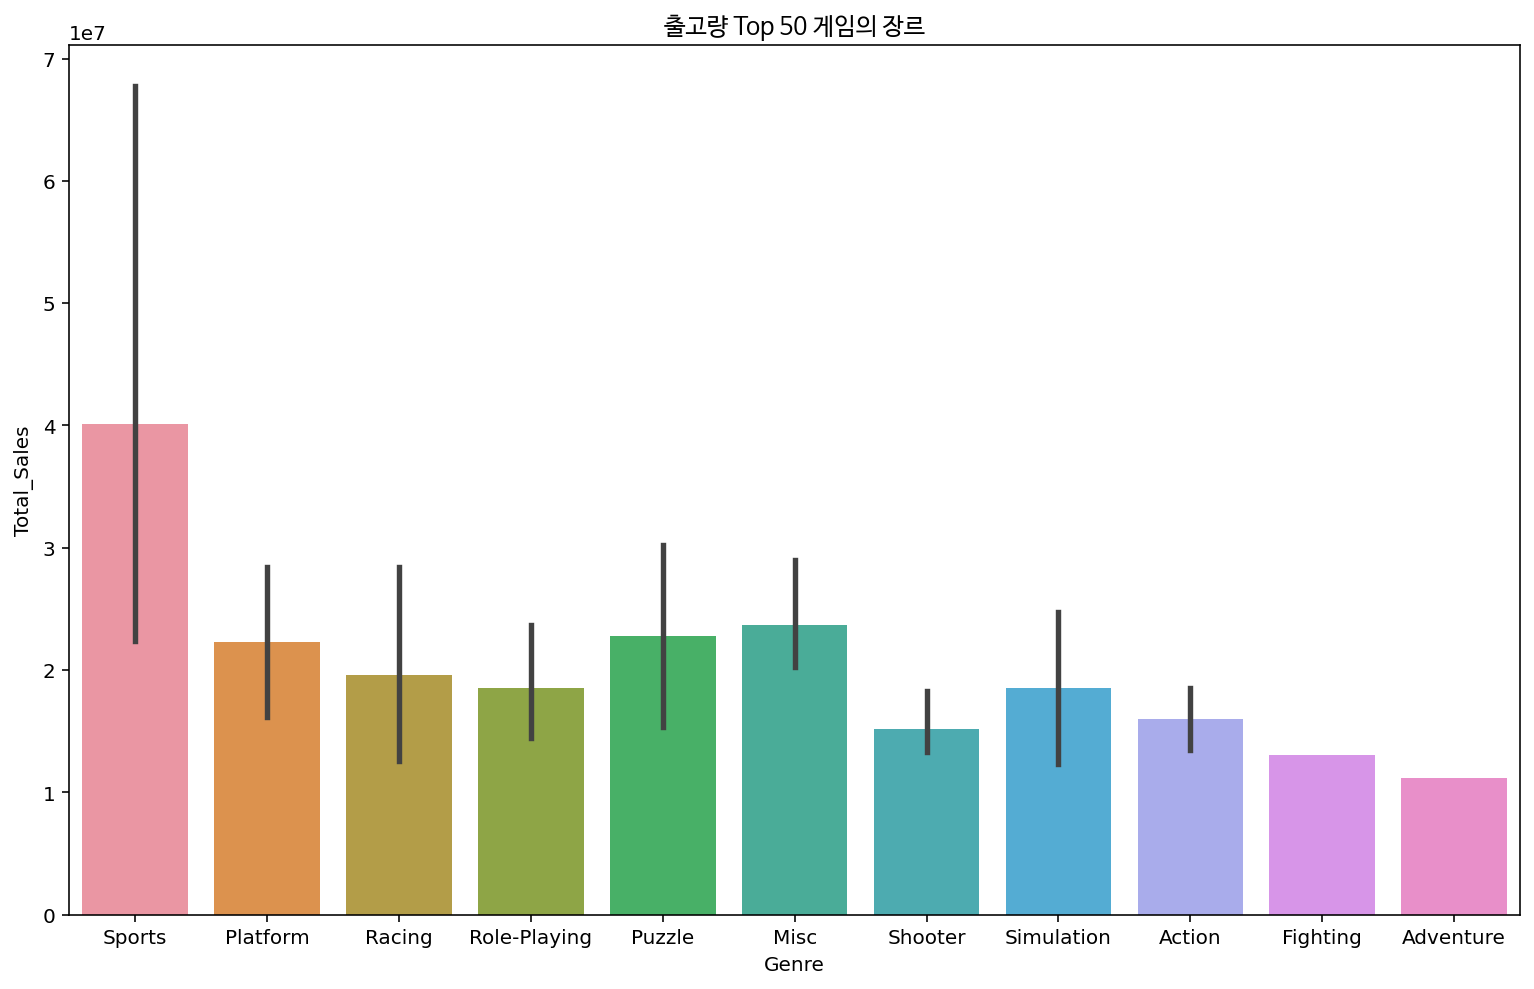

In [106]:
plt.figure(figsize=(13,8))
sns.barplot(data = df_max_G, x='Genre', y='Total_Sales')
plt.title('출고량 Top 50 게임의 장르', fontproperties = fontprop)
plt.show();

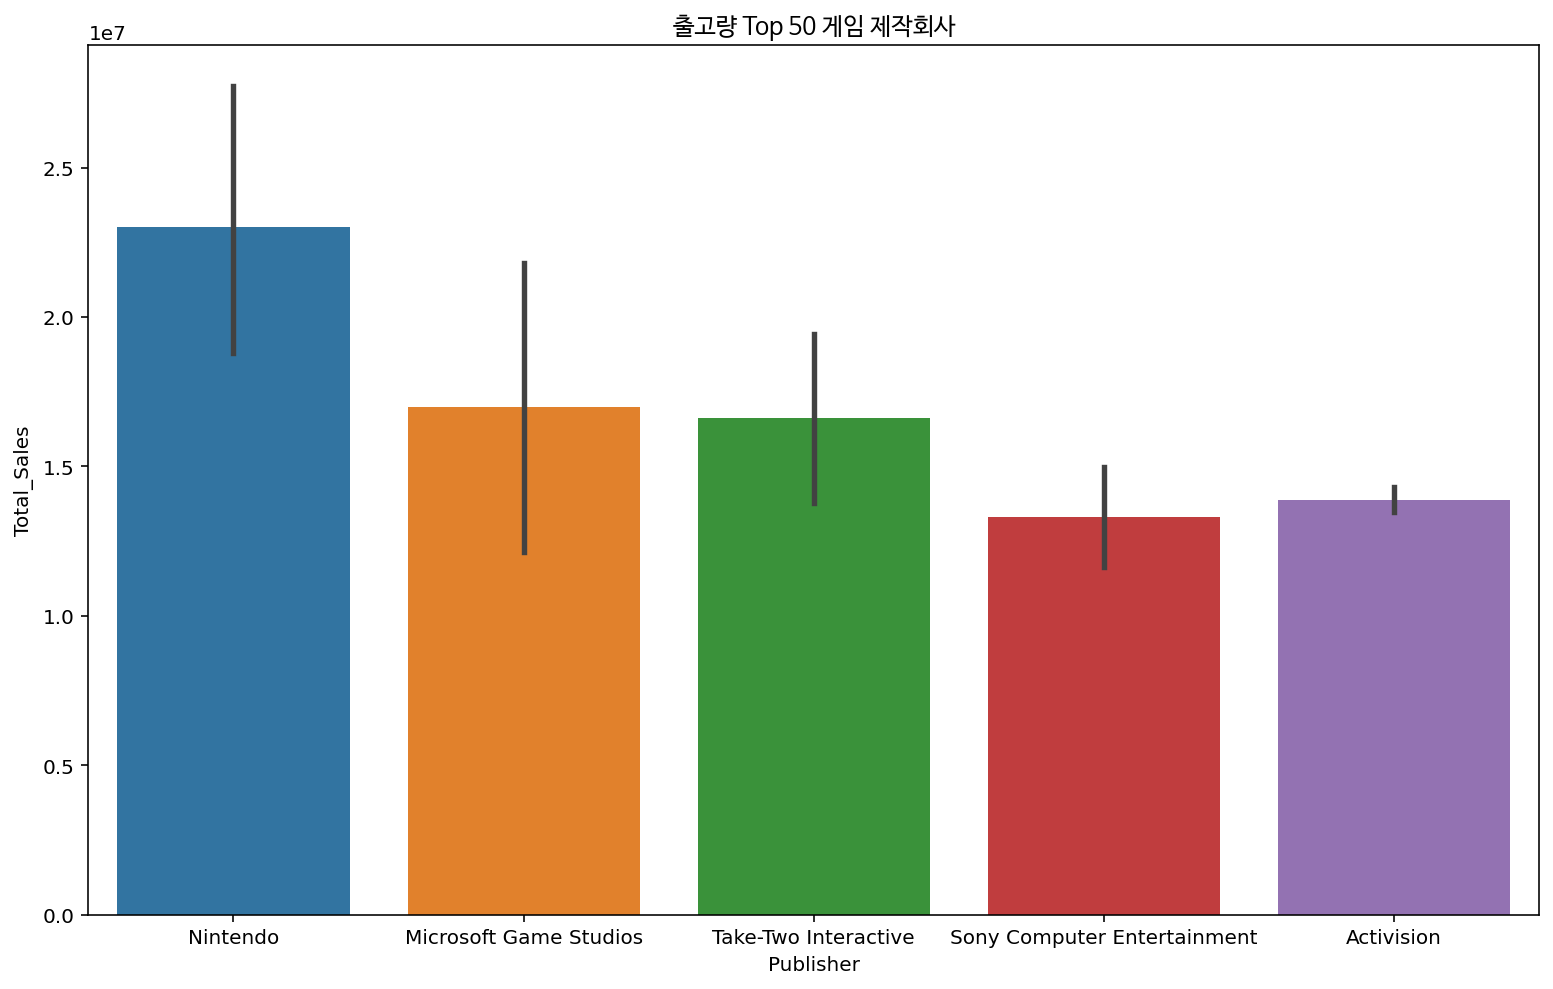

In [107]:
plt.figure(figsize=(13,8))
sns.barplot(data = df_max_G, x='Publisher', y='Total_Sales')
plt.title('출고량 Top 50 게임 제작회사', fontproperties = fontprop)
plt.show();

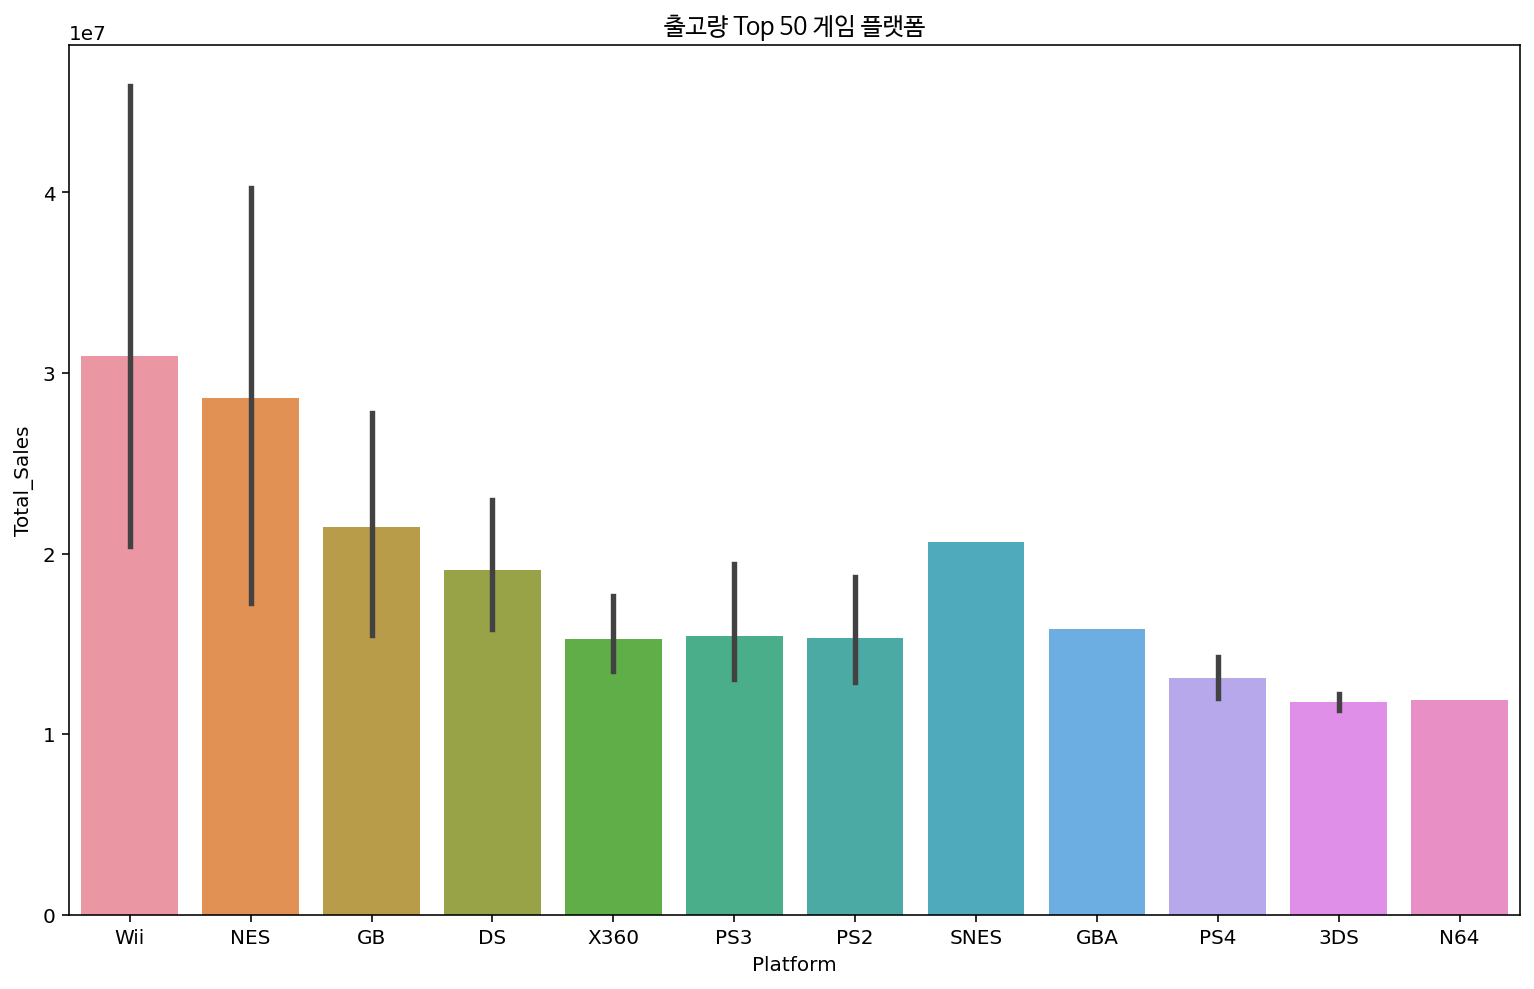

In [108]:
plt.figure(figsize=(13,8))
sns.barplot(data = df_max_G, x='Platform', y='Total_Sales')
plt.title('출고량 Top 50 게임 플랫폼', fontproperties = fontprop)
plt.show();

# **결론**



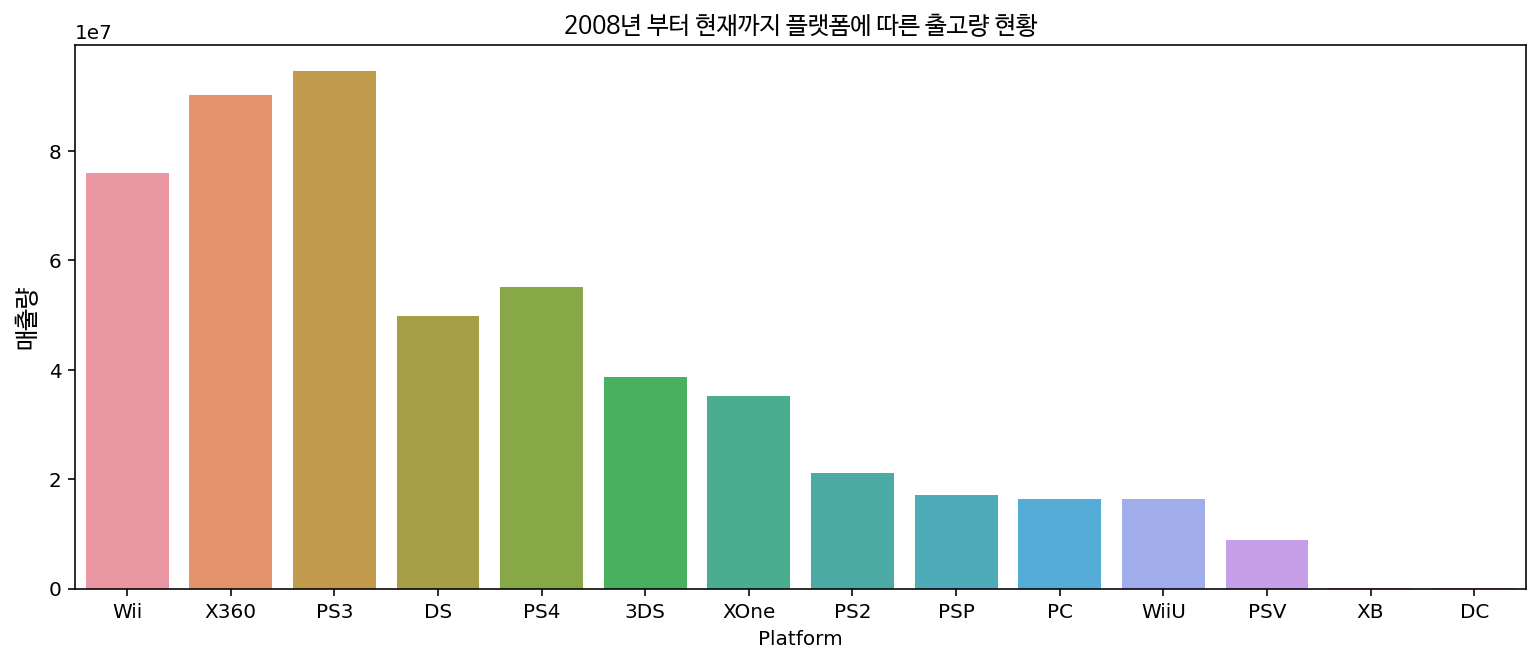

In [109]:

df_PF = df_reset.copy()
df_PF['Year'] = df_PF['Year'].astype(int)
df_PF1 = df_PF[(df_PF['Year'] >= 2008)][['Platform','Year','Total_Sales']].groupby(['Platform','Year']).sum().reset_index()
df_PF1 = df_PF1.sort_values(by='Total_Sales', ascending=False)

plt.figure(figsize=(13,5))
sns.barplot(data=df_PF1, y='Total_Sales', x='Platform', ci=None)
plt.title('2008년 부터 현재까지 플랫폼에 따른 출고량 현황', fontproperties = fontprop)
plt.ylabel('매출량', fontproperties = fontprop)
plt.show();

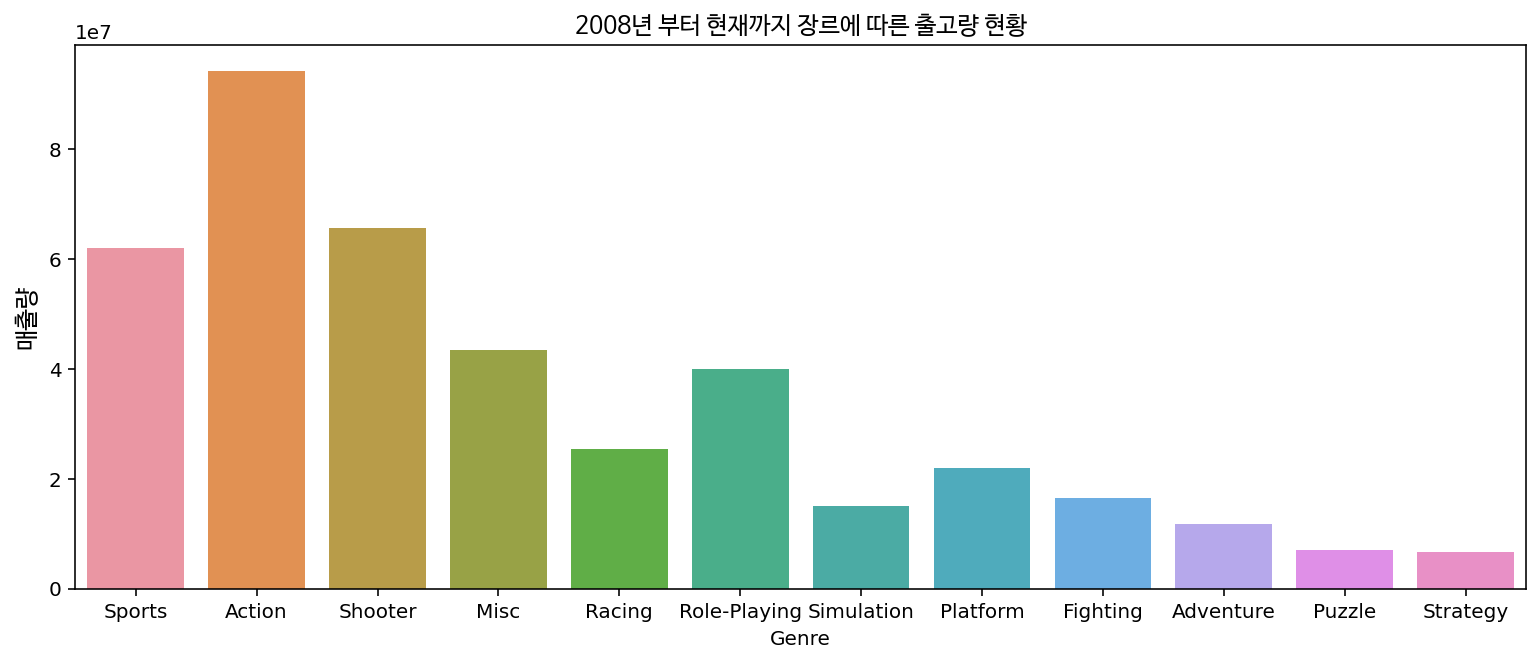

In [110]:
plt.figure(figsize=(13,5))
df_PF2 = df_PF[(df_PF['Year'] >= 2008)][['Genre','Year','Total_Sales']].groupby(['Genre','Year']).sum().reset_index()
df_PF2 = df_PF2.sort_values(by='Total_Sales', ascending=False)
sns.barplot(data=df_PF2, y='Total_Sales', x='Genre', ci=None)
plt.title('2008년 부터 현재까지 장르에 따른 출고량 현황', fontproperties = fontprop)
plt.ylabel('매출량', fontproperties = fontprop)
plt.show();

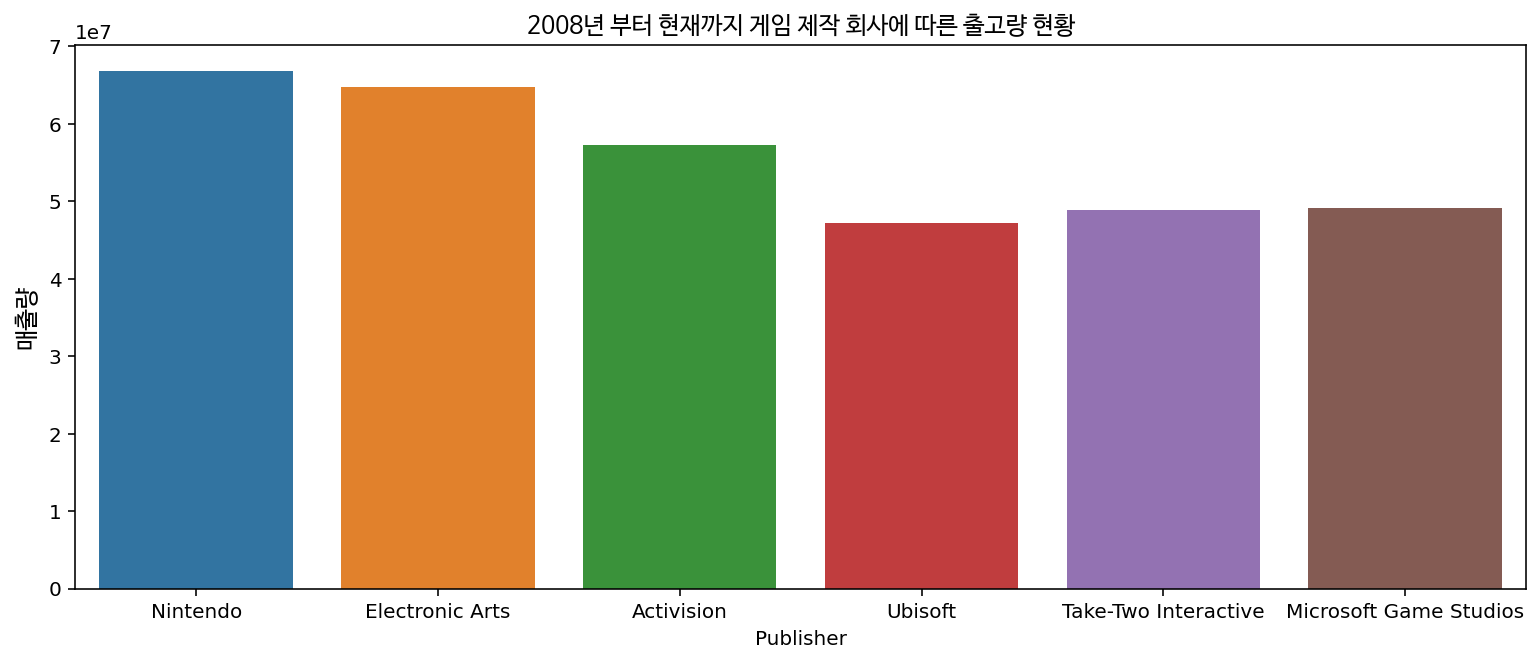

In [111]:
plt.figure(figsize=(13,5))
df_PF3 = df_PF[(df_PF['Year'] >= 2008)][['Publisher','Year','Total_Sales']].groupby(['Publisher','Year']).sum().reset_index()
df_PF3 = df_PF3.sort_values(by='Total_Sales', ascending=False).head(30)
sns.barplot(data=df_PF3, y='Total_Sales', x='Publisher', ci=None)
plt.title('2008년 부터 현재까지 게임 제작 회사에 따른 출고량 현황', fontproperties = fontprop)
plt.ylabel('매출량', fontproperties = fontprop)
plt.show();

In [112]:
df_PF[(df_PF['Year'] >= 2008)].sort_values(['Total_Sales'], axis=0, ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3275,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
10643,Wii Fit Plus,Wii,2009,Sports,Nintendo,9090000,8590000,2530000,1790000,22000000
4237,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14970000,4940000,240000,1670000,21820000
3401,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7010000,9270000,970000,4139999,21389999
10657,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9630000,5310000,60000,1380000,16380000
10372,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5570000,3280000,5650000,820000,15320000
2746,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9030000,4280000,130000,1320000,14760000
6099,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9670000,3730000,110000,1130000,14640000


In [56]:
df_PF[(df_PF['Year'] >= 2008)].sort_values(['NA_Sales'], axis=0, ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3275,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
4237,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14970000,4940000,240000,1670000,21820000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
6099,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9670000,3730000,110000,1130000,14640000
10657,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9630000,5310000,60000,1380000,16380000
10643,Wii Fit Plus,Wii,2009,Sports,Nintendo,9090000,8590000,2530000,1790000,22000000
2746,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9030000,4280000,130000,1320000,14760000
6087,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8520000,3630000,80000,1290000,13520000
6237,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8250000,4300000,70000,1120000,13740000


In [57]:
df_PF[(df_PF['Year'] >= 2008)].sort_values(['EU_Sales'], axis=0, ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3275,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
3401,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7010000,9270000,970000,4139999,21389999
10643,Wii Fit Plus,Wii,2009,Sports,Nintendo,9090000,8590000,2530000,1790000,22000000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
5303,The Sims 3,PC,2009,Simulation,Electronic Arts,980000,6420000,0,710000,8110000
2576,FIFA 16,PS4,2015,Sports,Electronic Arts,1110000,6060000,60000,1260000,8490000
4136,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4990000,5880000,650000,2520000,14040000
13771,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5540000,5820000,490000,1620000,13470000
1966,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3800000,5810000,360000,2020000,11990000


In [58]:
df_PF[(df_PF['Year'] >= 2008)].sort_values(['JP_Sales'], axis=0, ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
10372,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5570000,3280000,5650000,820000,15320000
1810,Monster Hunter Freedom 3,PSP,2010,Role-Playing,Capcom,0,0,4870000,0,4870000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
8699,Animal Crossing: New Leaf,3DS,2012,Simulation,Nintendo,2009999,2320000,4360000,410000,9099999
5089,Dragon Quest IX: Sentinels of the Starry Skies,DS,2009,Role-Playing,Nintendo,660000,690000,4350000,150000,5850000
4421,Monster Hunter Freedom Unite,PSP,2008,Role-Playing,Capcom,470000,570000,4130000,340000,5510000
4686,Pokemon HeartGold/Pokemon SoulSilver,DS,2009,Action,Nintendo,4400000,2770000,3960000,770000,11900000
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
8025,Friend Collection,DS,2009,Misc,Nintendo,0,0,3670000,0,3670000
15283,Monster Hunter 4,3DS,2013,Role-Playing,Capcom,0,0,3440000,0,3440000


In [59]:
df_PF[(df_PF['Year'] >= 2008)].sort_values(['Other_Sales'], axis=0, ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
3401,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7010000,9270000,970000,4139999,21389999
12275,Mario Kart Wii,Wii,2008,Racing,Nintendo,15850000,12880000,3790000,3310000,35830000
3275,Wii Sports Resort,Wii,2009,Sports,Nintendo,15750000,11010000,3280000,2960000,33000000
4136,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4990000,5880000,650000,2520000,14040000
8860,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5770000,5810000,350000,2310000,14240000
16123,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14590000,7060000,4700000,2260000,28610000
6068,Gran Turismo 5,PS3,2010,Racing,Sony Computer Entertainment,2960000,4880000,810000,2120000,10770000
14851,PES 2009: Pro Evolution Soccer,PS2,2008,Sports,Konami Digital Entertainment,130000,70000,260000,2049999,2509999
1966,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3800000,5810000,360000,2020000,11990000
8825,FIFA Soccer 13,PS3,2012,Action,Electronic Arts,1060000,5050000,130000,2009999,8249999


          Genre Platform  Total_Sales
8        Action      PS2    264789999
140      Sports      PS2    256399997
143      Sports      Wii    251089999
86       Racing      PS2    152419998
49         Misc      Wii    126890000
120  Simulation       DS    121060000
39         Misc       DS    118389999
118     Shooter     X360    116200000
114     Shooter      PS2    107880000
9        Action      PS3     99040000


AttributeError: ignored

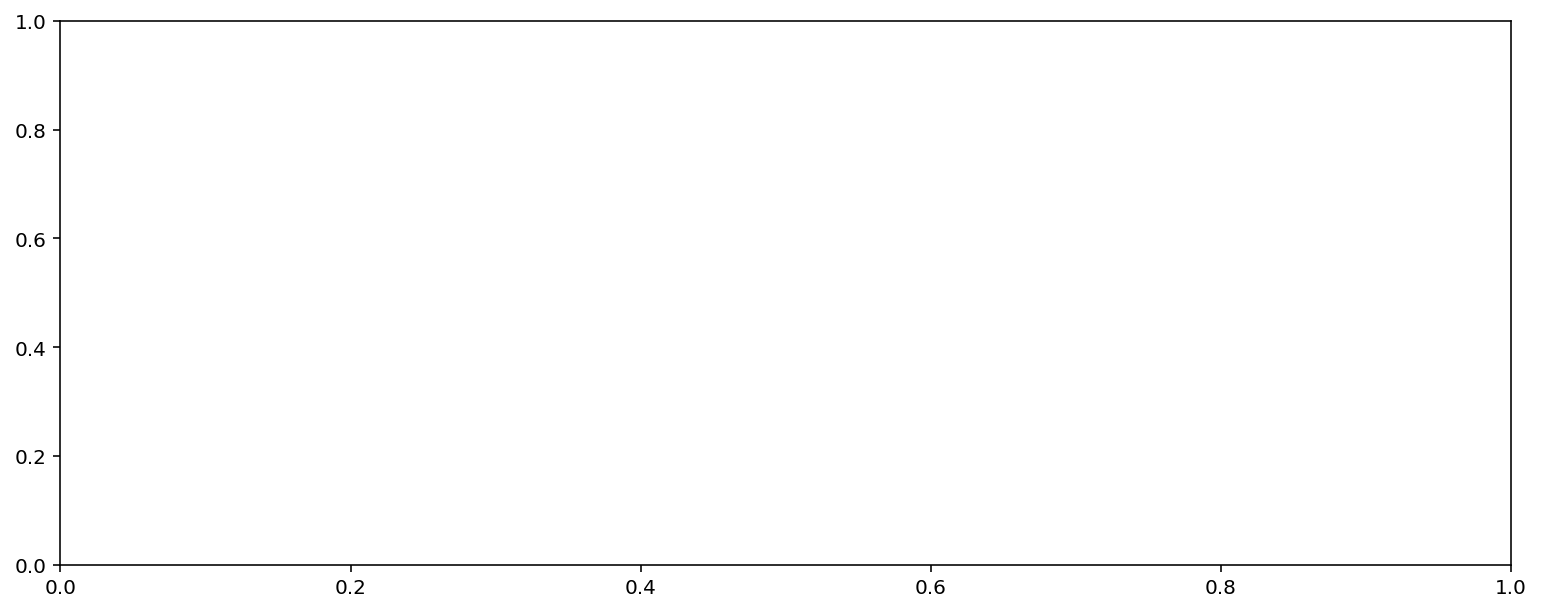

In [156]:

df_PF4 = df_PF[(df_PF['Year'] >= 2000)&(df_PF['Year'] < 2010)][['Platform','Genre','Total_Sales']].groupby(['Genre','Platform']).sum().reset_index().sort_values(by='Total_Sales', ascending=False).head(10)

print(df_PF4)

df_PF5 = pd.crosstab(index=df_PF4['Genre'], columns=df_PF4['Platform'], values=df_PF4['Total_Sales'], aggfunc='sum').fillna(0)
df_PF5['total']=df_PF5.sum(axis=1)
df_PF5 = df_PF5.sort_values(by='total', ascending=False).head(10)
df_PF5
df_PF5.drop('total', axis=1).plot.barh(stacked=True, figsize=(13,5), palette='pastel')
plt.title('2000-2009 출고량 Top 10 장르와 플랫폼', fontproperties = fontprop)
plt.xlabel('Total Sales');

            Genre Platform  Total_Sales
4          Action      PS3    202449998
102       Shooter     X360    160939999
10         Action     X360    145590000
96        Shooter      PS3    131340000
119        Sports      PS3     90270000
125        Sports     X360     84820000
5          Action      PS4     84700000
44           Misc      Wii     81349999
97        Shooter      PS4     75319998
80   Role-Playing      3DS     61340000


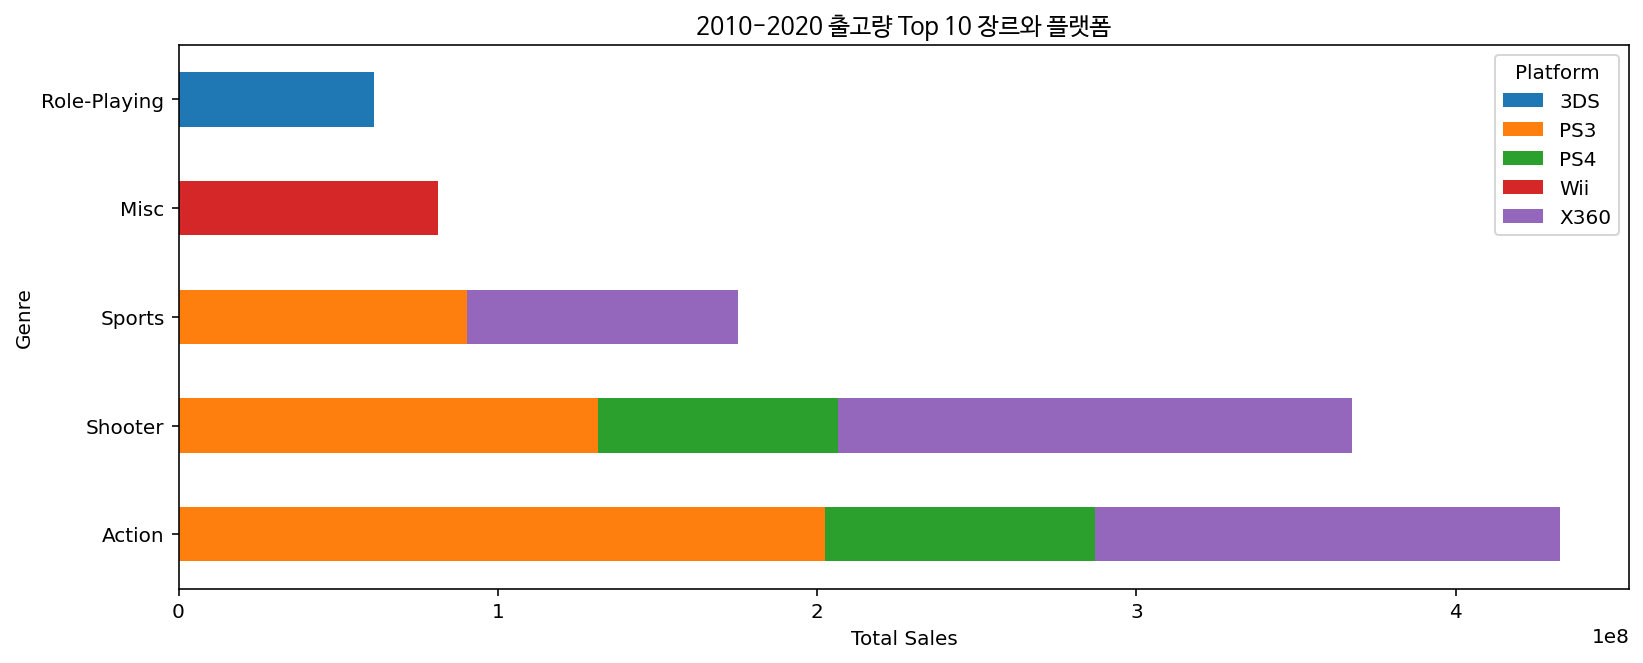

In [151]:

df_PF4 = df_PF[(df_PF['Year'] >= 2010)][['Platform','Genre','Total_Sales']].groupby(['Genre','Platform']).sum().reset_index().sort_values(by='Total_Sales', ascending=False).head(10)

print(df_PF4)

df_PF5 = pd.crosstab(index=df_PF4['Genre'], columns=df_PF4['Platform'], values=df_PF4['Total_Sales'], aggfunc='sum').fillna(0)
df_PF5['total']=df_PF5.sum(axis=1)
df_PF5 = df_PF5.sort_values(by='total', ascending=False).head(10)
df_PF5
df_PF5.drop('total', axis=1).plot.barh(stacked=True, figsize=(13,5))
plt.title('2010-2020 출고량 Top 10 장르와 플랫폼', fontproperties = fontprop)
plt.xlabel('Total Sales');